In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py

In [2]:
from pm_pd_utils import initial_dataframe_analysis
import warnings
warnings.filterwarnings("ignore")

In [3]:
DATA_FILE_PATH = 'data/augmented_dispatch_event_log.parquet'
df = pd.read_parquet(DATA_FILE_PATH)
df = df.drop(columns=['shiftname.1'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(3)

,case_id,activity,timestamp,resource,crew,shiftname,loadlocationunit,excav,loadlocation,truck
0,0,Assign Carga,2024-03-26 07:58:02+00:00,Darwin Orellana Rojo,G4,240326a,Disparo,PA,F11,CA94
1,0,Arrive Carga,2024-03-26 08:07:39+00:00,Darwin Orellana Rojo,G4,240326a,Disparo,PA,F11,CA94
2,0,Spotting Carga,2024-03-26 08:07:39+00:00,Darwin Orellana Rojo,G4,240326a,Disparo,PA,F11,CA94


In [5]:
print('Load Location Units:', ', '.join(df['loadlocationunit'].unique().tolist()))
print('Load Location:      ', ', '.join(df['loadlocation'].unique().tolist()))

Load Location Units: Disparo, Stock, Nodo, Taller
Load Location:       F11, F9, F12, STOC, F10, P21, S00, M17, M21, M18, M47, CUBICULOS-ENAEX, M7


In [6]:
def ordered_series(df: pd.Series) -> list[str]:
  return df.value_counts().index

<Axes: xlabel='loadlocation', ylabel='count'>

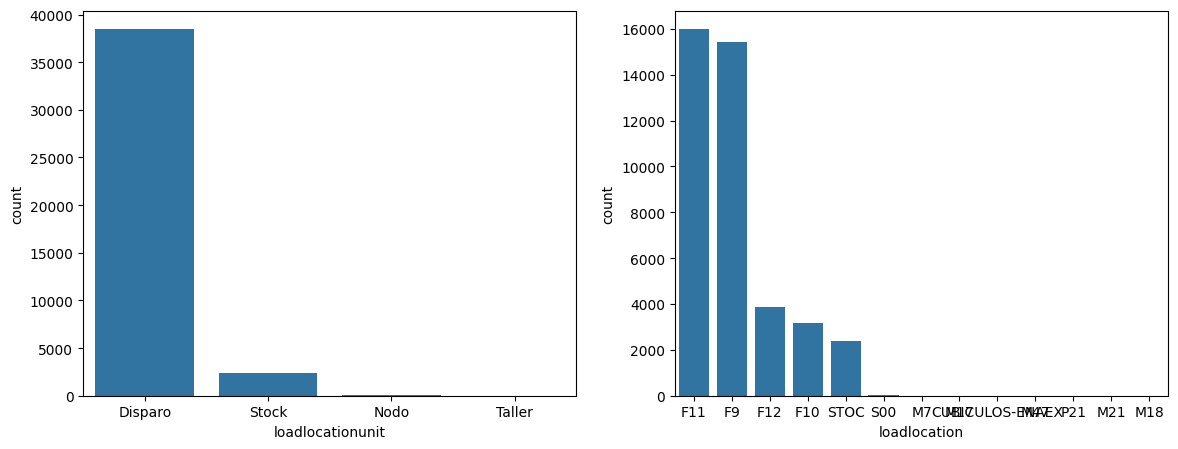

In [7]:
# Plot the frecuencies of load_location_unit and load_location
df_not_repeated = df[['case_id', 'loadlocationunit', 'loadlocation']].groupby('case_id').first()
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 5))
sns.countplot(data=df_not_repeated, x='loadlocationunit', ax=ax1, order=ordered_series(df_not_repeated['loadlocationunit']))
sns.countplot(data=df_not_repeated, x='loadlocation', ax=ax2, order=ordered_series(df_not_repeated['loadlocation']))

In [8]:
# Cut the cases where the count is less than this threshold
THRESHOLD = 50 * 8
def list_to_keep(df: pd.DataFrame, column: str, threshold: int = THRESHOLD) -> list[str]:
  """
    For a categorical column returns a list of items that are repeated with more or equal than a "THRESHOLD" value
  """
  series_keep = df[column].value_counts() >= threshold
  return series_keep[series_keep].index.tolist()

load_location_keep = list_to_keep(df, 'loadlocation')
load_location_unit_keep = list_to_keep(df, 'loadlocationunit')
df_filtered = df[df['loadlocation'].isin(load_location_keep) & df['loadlocationunit'].isin(load_location_unit_keep)]

In [9]:
print(f'Filtered from {df.shape[0]:_} rows to {df_filtered.shape[0]:_}. {(df.shape[0] - df_filtered.shape[0]):_} rows filtered')

Filtered from 368_307 rows to 367_911. 396 rows filtered


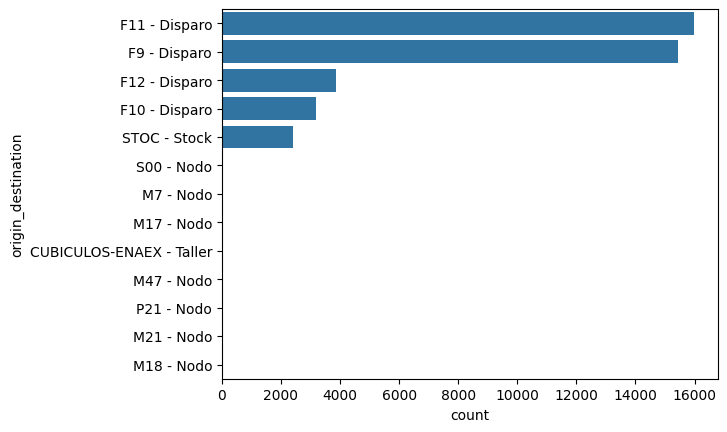

In [10]:
# Create an artificial column that contains both loadlocation and loadlocationunit and count what combination is most repeated
df_not_repeated['origin_destination'] = df_not_repeated['loadlocation'].str.cat(df_not_repeated['loadlocationunit'], sep=' - ')
sns.countplot(df_not_repeated['origin_destination'], order=df_not_repeated['origin_destination'].value_counts().index);

In [11]:
origin_destination_to_keep = list_to_keep(df_not_repeated, 'origin_destination')
df_full_filtered = df_not_repeated[df_not_repeated['origin_destination'].isin(origin_destination_to_keep)]

In [12]:
print(f'Filtered from {df_not_repeated.shape[0]:_} rows to {df_full_filtered.shape[0]:_}. Total of {(df_not_repeated.shape[0] - df_full_filtered.shape[0]):_} rows filtered')

Filtered from 40_923 rows to 40_879. Total of 44 rows filtered


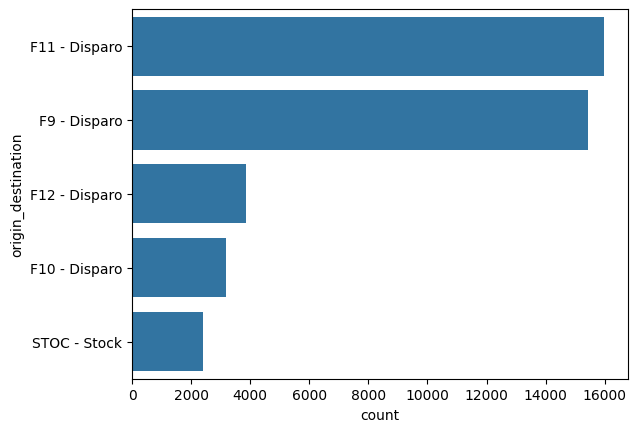

In [13]:
sns.countplot(df_full_filtered['origin_destination']);

In [14]:
df_to_analyze = df.merge(df_full_filtered.reset_index()[['case_id', 'origin_destination']], how='inner', on='case_id')

In [15]:
for index, field in enumerate(df_to_analyze['origin_destination'].value_counts().index.tolist()):
  print(f'{index + 1}) "{field}"')

1) "F11 - Disparo"
2) "F9 - Disparo"
3) "F12 - Disparo"
4) "F10 - Disparo"
5) "STOC - Stock"


In [16]:
def plot_dfg_from_df(df: pd.DataFrame, origin_destination_column: str):
  df_filtered = df[df['origin_destination'] == origin_destination_column]
  print(f'The data with origin - destination <{origin_destination_column}> rows: {df_filtered.groupby('case_id').ngroups}')
  event_log_filtered, _, _ = initial_dataframe_analysis(df_filtered, with_dfg=True)
  return df_filtered, event_log_filtered

The data with origin - destination <F10 - Disparo> rows: 3173


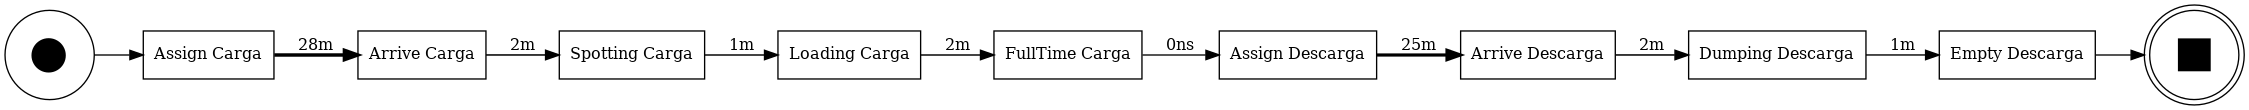

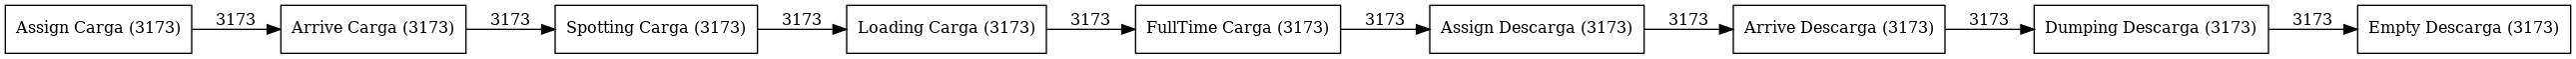

In [17]:
# df_f10_disparo = df_to_analyze[df_to_analyze['origin_destination'] == 'F10 - Disparo']
df_f10_disparo, _ = plot_dfg_from_df(df_to_analyze, 'F10 - Disparo')

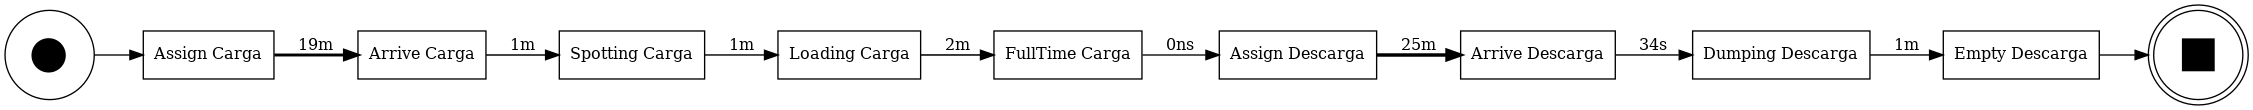

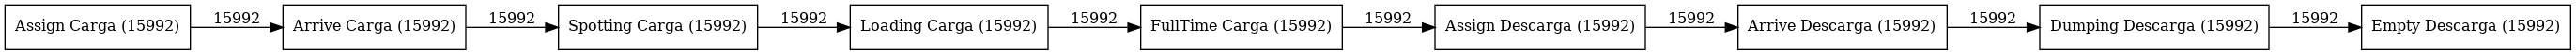

In [18]:
df_f11_disparo = df_to_analyze[df_to_analyze['origin_destination'] == 'F11 - Disparo']
event_log_f11_disparo, _, _ = initial_dataframe_analysis(df_f11_disparo, with_dfg=True)

The data with origin - destination <F12 - Disparo> rows: 3870


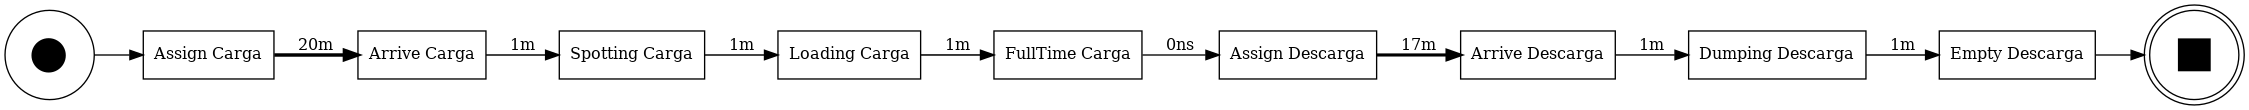

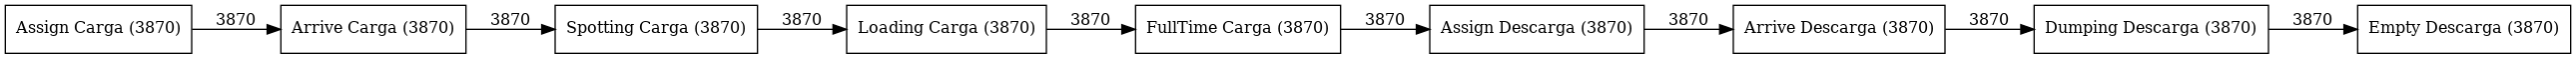

In [19]:
df_f12_disparo, _ = plot_dfg_from_df(df_to_analyze, 'F12 - Disparo');

The data with origin - destination <F9 - Disparo> rows: 15440


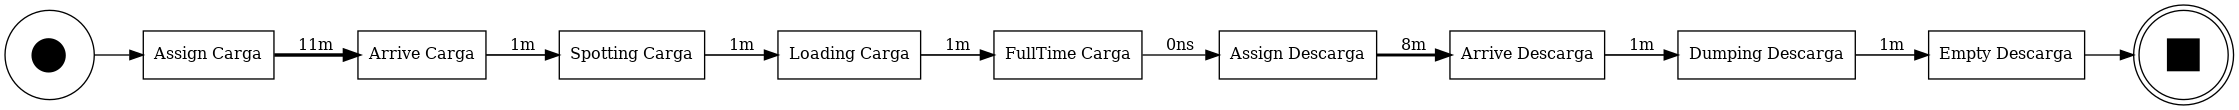

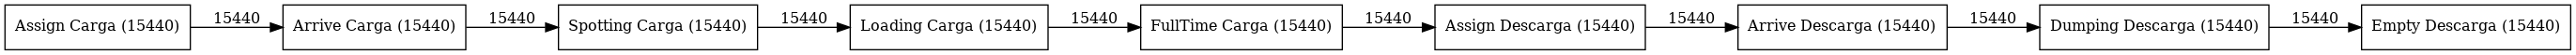

In [20]:
df_f9_disparo, _ = plot_dfg_from_df(df_to_analyze, 'F9 - Disparo');

The data with origin - destination <STOC - Stock> rows: 2404


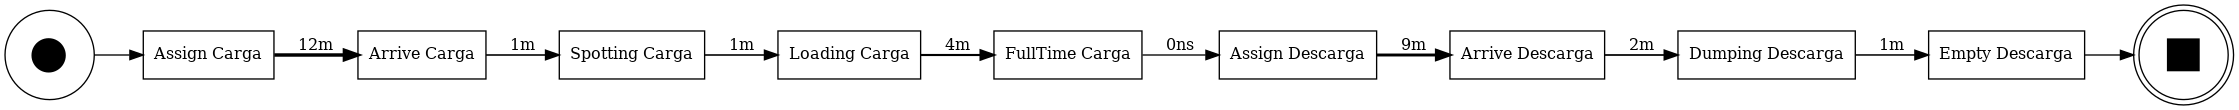

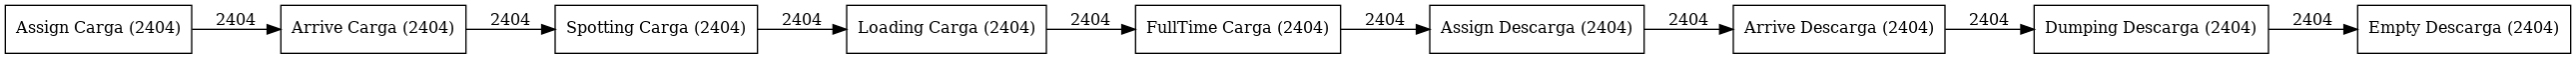

In [21]:
df_stock, _ = plot_dfg_from_df(df_to_analyze, 'STOC - Stock');

In [22]:
df_stock['timediff'] = df_stock[['case_id', 'timestamp']].groupby('case_id')['timestamp'].diff().dt.total_seconds() / 60

In [26]:
def obtain_time_metrics_between_activities(df: pd.DataFrame, activities: list[str]):
  # TODO: raise error if the activities are not in the dataframe
  set_unique_activities = set(df['activity'].unique().tolist())
  if len(set(activities) - set(set_unique_activities)) > 0:
    raise Exception(f'Cannot use this activities: {', '.join([*activities])}')
  df_activities = df[df['activity'].isin(activities)]
  return (df_activities.groupby(by='case_id')['timestamp'].diff().dt.total_seconds() / 60).dropna().describe().to_dict()
  
obtain_time_metrics_between_activities(df_stock, ['Assign Carga', 'Arrive Carga'])

{'count': 2404.0,
 'mean': 12.370424292845257,
 'std': 27.307575621819275,
 'min': 0.0,
 '25%': 3.3,
 '50%': 6.216666666666667,
 '75%': 10.174999999999999,
 'max': 515.4}

In [27]:
def df_with_paired_activities_timestamp(df: pd.DataFrame) -> pd.DataFrame:
  """
    Function to pivot data and show times in columns, alternative option to obtain_time_metrics_between_activities
  """
  return pd.pivot(df[df['activity'].isin(['Assign Carga', 'Arrive Carga'])], index='case_id', columns=['activity'], values='timestamp')

In [28]:
from itertools import pairwise
unique_activities = df['activity'].unique().tolist()
PAIRED_ACTIVITIES = [*pairwise(unique_activities)]

In [29]:
def obtain_delta_time_metrics(df: pd.DataFrame, df_name: str) -> list[dict]:
  return [{'origin_destination': df_name,
           'initial_activity': pair_activity[0],
           'final_activity': pair_activity[1],
            **obtain_time_metrics_between_activities(df, pair_activity)} 
         for pair_activity in PAIRED_ACTIVITIES]

In [30]:
list_segmented_df = [df_f9_disparo, df_f10_disparo, df_f11_disparo, df_f12_disparo, df_stock]
df_names = ['f9_disparo', 'f10_disparo', 'f11_disparo', 'f12_disparo', 'stock']

df_metrics = [pd.DataFrame(data=obtain_delta_time_metrics(df, df_name)) for df, df_name in zip(list_segmented_df, df_names)]

In [31]:
summary_per_df = pd.concat(df_metrics).rename(columns={'50%': 'median'}).drop(columns=['std', '25%', 'min', '75%', 'max'])
summary_per_df.head(10)

,origin_destination,initial_activity,final_activity,count,mean,median
0,f9_disparo,Assign Carga,Arrive Carga,15440.0,11.416753,4.333333
1,f9_disparo,Arrive Carga,Spotting Carga,15440.0,1.742359,0.216667
2,f9_disparo,Spotting Carga,Loading Carga,15440.0,1.322007,1.066667
3,f9_disparo,Loading Carga,FullTime Carga,15440.0,1.956229,1.466667
4,f9_disparo,FullTime Carga,Assign Descarga,15440.0,0.000000,0.000000
5,f9_disparo,Assign Descarga,Arrive Descarga,15440.0,8.703502,5.700000
6,f9_disparo,Arrive Descarga,Dumping Descarga,15440.0,1.893271,0.983333
7,f9_disparo,Dumping Descarga,Empty Descarga,15440.0,1.100972,1.016667
0,f10_disparo,Assign Carga,Arrive Carga,3173.0,28.314004,21.833333
1,f10_disparo,Arrive Carga,Spotting Carga,3173.0,2.864282,0.516667


In [139]:
summary_per_df.groupby(by="origin_destination")['mean'].sum().to_frame().reset_index()

,origin_destination,mean
0,f10_disparo,63.283838
1,f11_disparo,52.360889
2,f12_disparo,44.315448
3,f9_disparo,28.135092
4,stock,33.074355


In [34]:
summary_per_df.to_csv('data/summary_per_df.csv', index=False)

In [48]:
summary_per_df.head()

,origin_destination,initial_activity,final_activity,count,mean,median
0,f9_disparo,Assign Carga,Arrive Carga,15440.0,11.416753,4.333333
1,f9_disparo,Arrive Carga,Spotting Carga,15440.0,1.742359,0.216667
2,f9_disparo,Spotting Carga,Loading Carga,15440.0,1.322007,1.066667
3,f9_disparo,Loading Carga,FullTime Carga,15440.0,1.956229,1.466667
4,f9_disparo,FullTime Carga,Assign Descarga,15440.0,0.000000,0.000000


In [42]:
summary_per_df[summary_per_df['initial_activity'] == 'Assign Carga']

,origin_destination,initial_activity,final_activity,count,mean,median
0,f9_disparo,Assign Carga,Arrive Carga,15440.0,11.416753,4.333333
0,f10_disparo,Assign Carga,Arrive Carga,3173.0,28.314004,21.833333
0,f11_disparo,Assign Carga,Arrive Carga,15992.0,19.818389,12.183333
0,f12_disparo,Assign Carga,Arrive Carga,3870.0,20.596499,17.808333
0,stock,Assign Carga,Arrive Carga,2404.0,12.370424,6.216667


In [43]:
idx_max_assign_carga_time = summary_per_df[summary_per_df['initial_activity'] == 'Assign Carga']['mean'].idxmax()
idx_max_assign_carga_time

0

In [58]:
# Formar las gaviotas
short_df = df_stock[['case_id', 'activity', 'timestamp', 'timediff']]
between_activities = ['Assign Carga', 'Empty Descarga'] # Here total time
df_first_act = short_df[short_df['activity'] == 'Assign Carga'].drop(columns=['timediff'])
df_timediff = short_df.groupby('case_id')['timediff'].sum().reset_index()


In [109]:
period = '15T'
df_merged = df_first_act.merge(df_timediff, on='case_id')
df_merged['truncated_ts'] = df_merged.drop(columns=['activity'])['timestamp'].dt.floor(period)

In [110]:
df_merged['format_hour'] = df_merged['truncated_ts'].dt.strftime('%H:%M')
df_merged['hour_sorted'] = df_merged['truncated_ts'].dt.strftime('%H.%M').astype(float)
df_merged['hour_sorted'] = df_merged['hour_sorted'].astype(int) + (df_merged['hour_sorted'] % 1) * 10 / 6

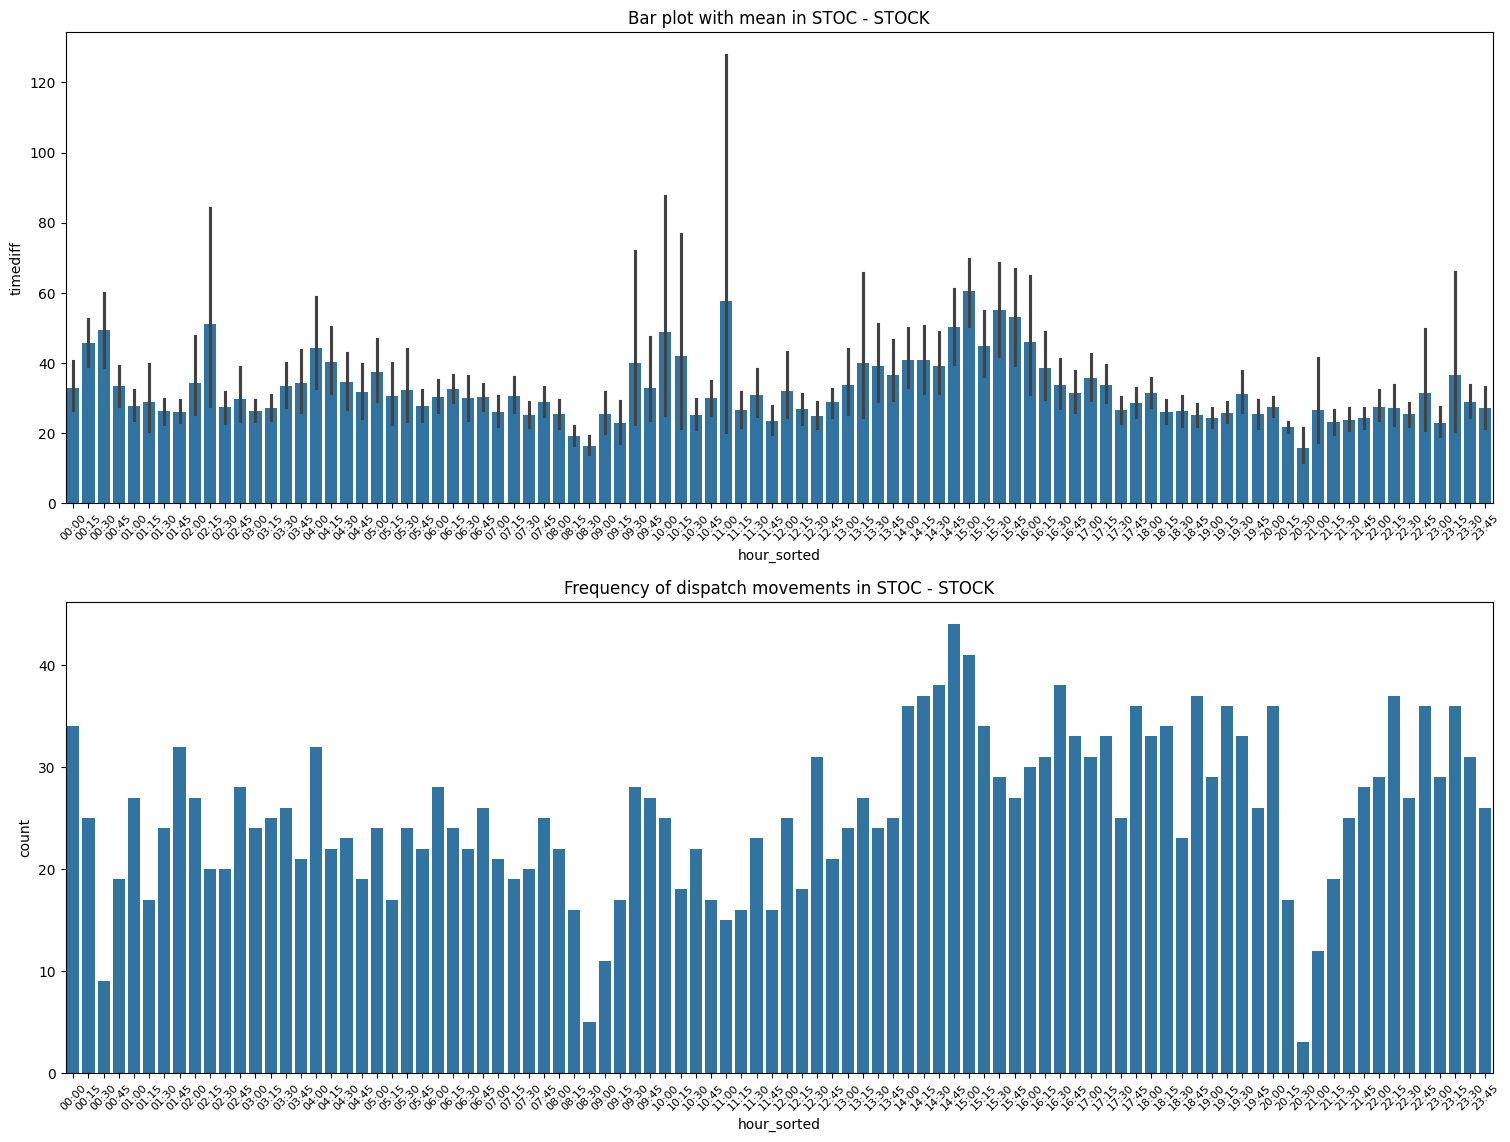

In [146]:
unique_ticks = df_merged[['hour_sorted', 'format_hour']].drop_duplicates().sort_values(by='hour_sorted')
fig, (ax1, ax2) = plt.subplots(figsize=(15, 11), ncols=1, nrows=2)
fig.tight_layout(h_pad=5)
sns.barplot(data=df_merged, x='hour_sorted', y='timediff', ax=ax1)
ax1.set_title(f'Bar plot with mean in {"STOC - STOCK"}')
ax1.set_xticklabels(unique_ticks['format_hour'], rotation=45, fontsize=8);
sns.countplot(data=df_merged, x='hour_sorted', ax=ax2)
ax2.set_title(f'Frequency of dispatch movements in {"STOC - STOCK"}')
ax2.set_xticklabels(unique_ticks['format_hour'], rotation=45, fontsize=8);

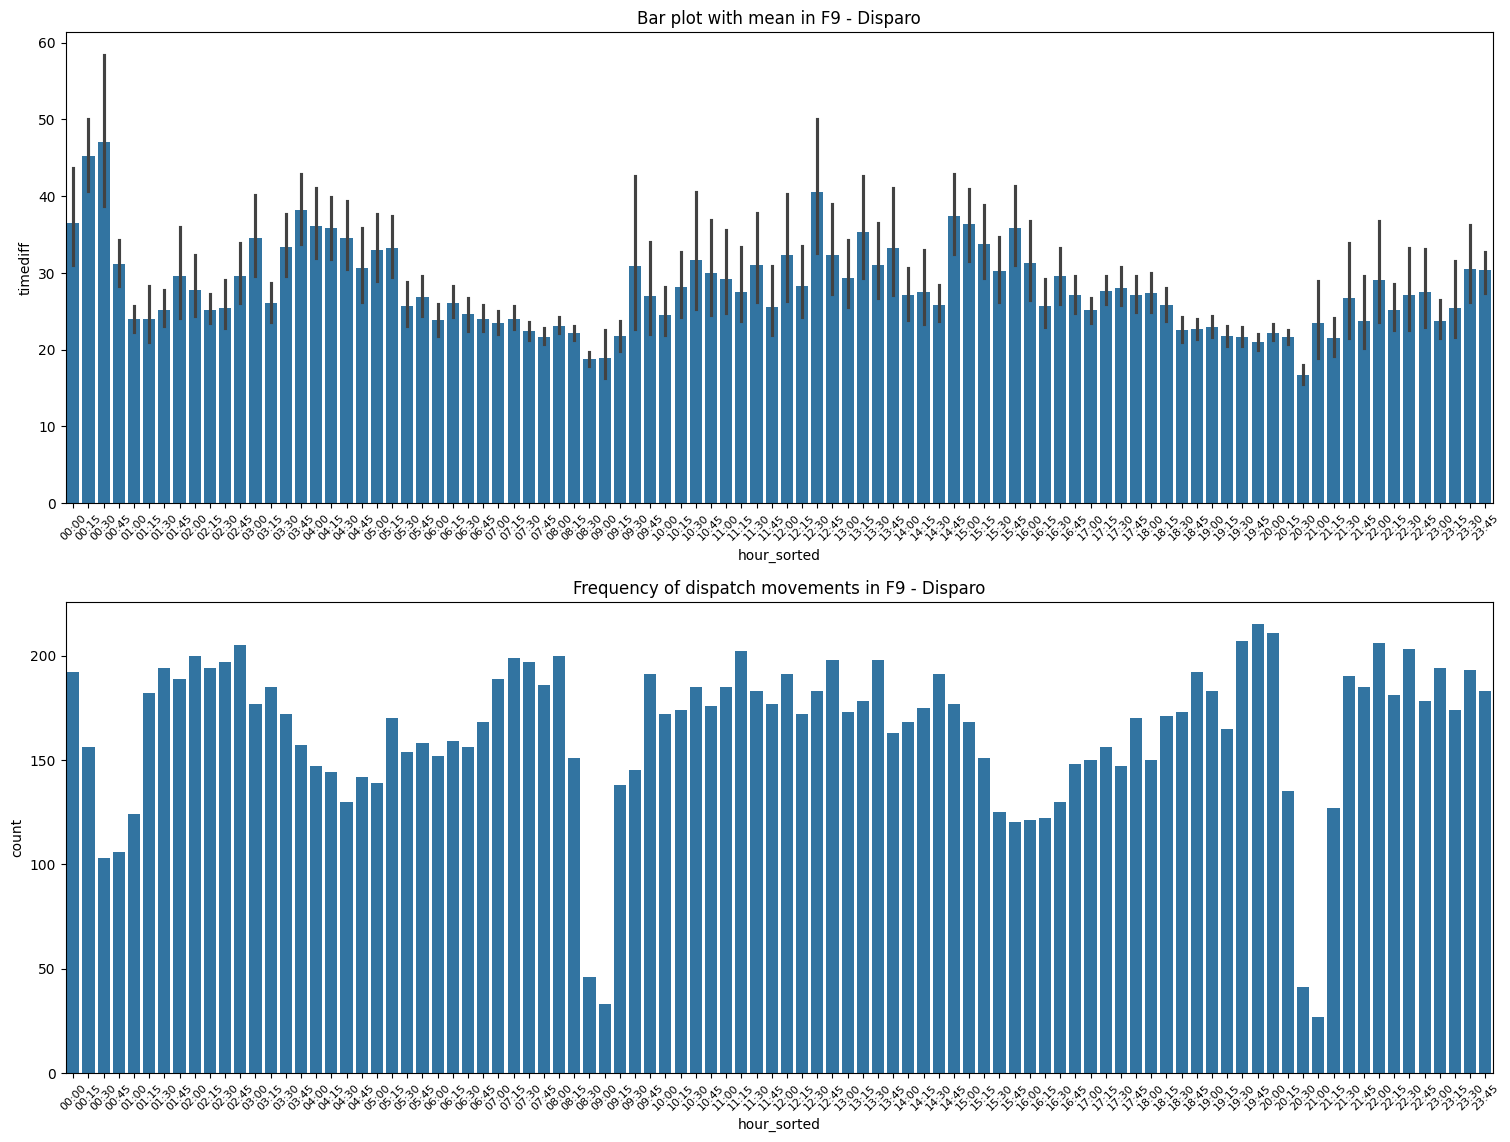

In [161]:
def plot_process_time(df: pd.DataFrame, origin_destination: str):
  df_copy = df.copy()
  df_copy['timediff'] = df_copy[['case_id', 'timestamp']].groupby('case_id')['timestamp'].diff().dt.total_seconds() / 60
  PERIOD = '15T'
  short_df = df_copy[['case_id', 'activity', 'timestamp', 'timediff']]
  between_activities = ['Assign Carga', 'Empty Descarga']
  df_first_act = short_df[short_df['activity'] == 'Assign Carga'].drop(columns=['timediff'])
  df_timediff = short_df.groupby('case_id')['timediff'].sum().reset_index()
  df_merged = df_first_act.merge(df_timediff, on='case_id')
  df_merged['truncated_ts'] = df_merged.drop(columns=['activity'])['timestamp'].dt.floor(PERIOD)
  df_merged['format_hour'] = df_merged['truncated_ts'].dt.strftime('%H:%M')
  df_merged['hour_sorted'] = df_merged['truncated_ts'].dt.strftime('%H.%M').astype(float)
  df_merged['hour_sorted'] = df_merged['hour_sorted'].astype(int) + (df_merged['hour_sorted'] % 1) * 10 / 6
  # Obtain unique values for the hour
  unique_ticks = df_merged[['hour_sorted', 'format_hour']].drop_duplicates().sort_values(by='hour_sorted')
  # Start figures
  fig, (ax1, ax2) = plt.subplots(figsize=(15, 11), ncols=1, nrows=2)
  fig.tight_layout(h_pad=5)
  sns.barplot(data=df_merged, x='hour_sorted', y='timediff', ax=ax1)
  ax1.set_title(f'Bar plot with mean in {origin_destination}')
  ax1.set_xticklabels(unique_ticks['format_hour'], rotation=45, fontsize=8);
  sns.countplot(data=df_merged, x='hour_sorted', ax=ax2)
  ax2.set_title(f'Frequency of dispatch movements in {origin_destination}')
  ax2.set_xticklabels(unique_ticks['format_hour'], rotation=45, fontsize=8);

plot_process_time(df_f9_disparo, 'F9 - Disparo');

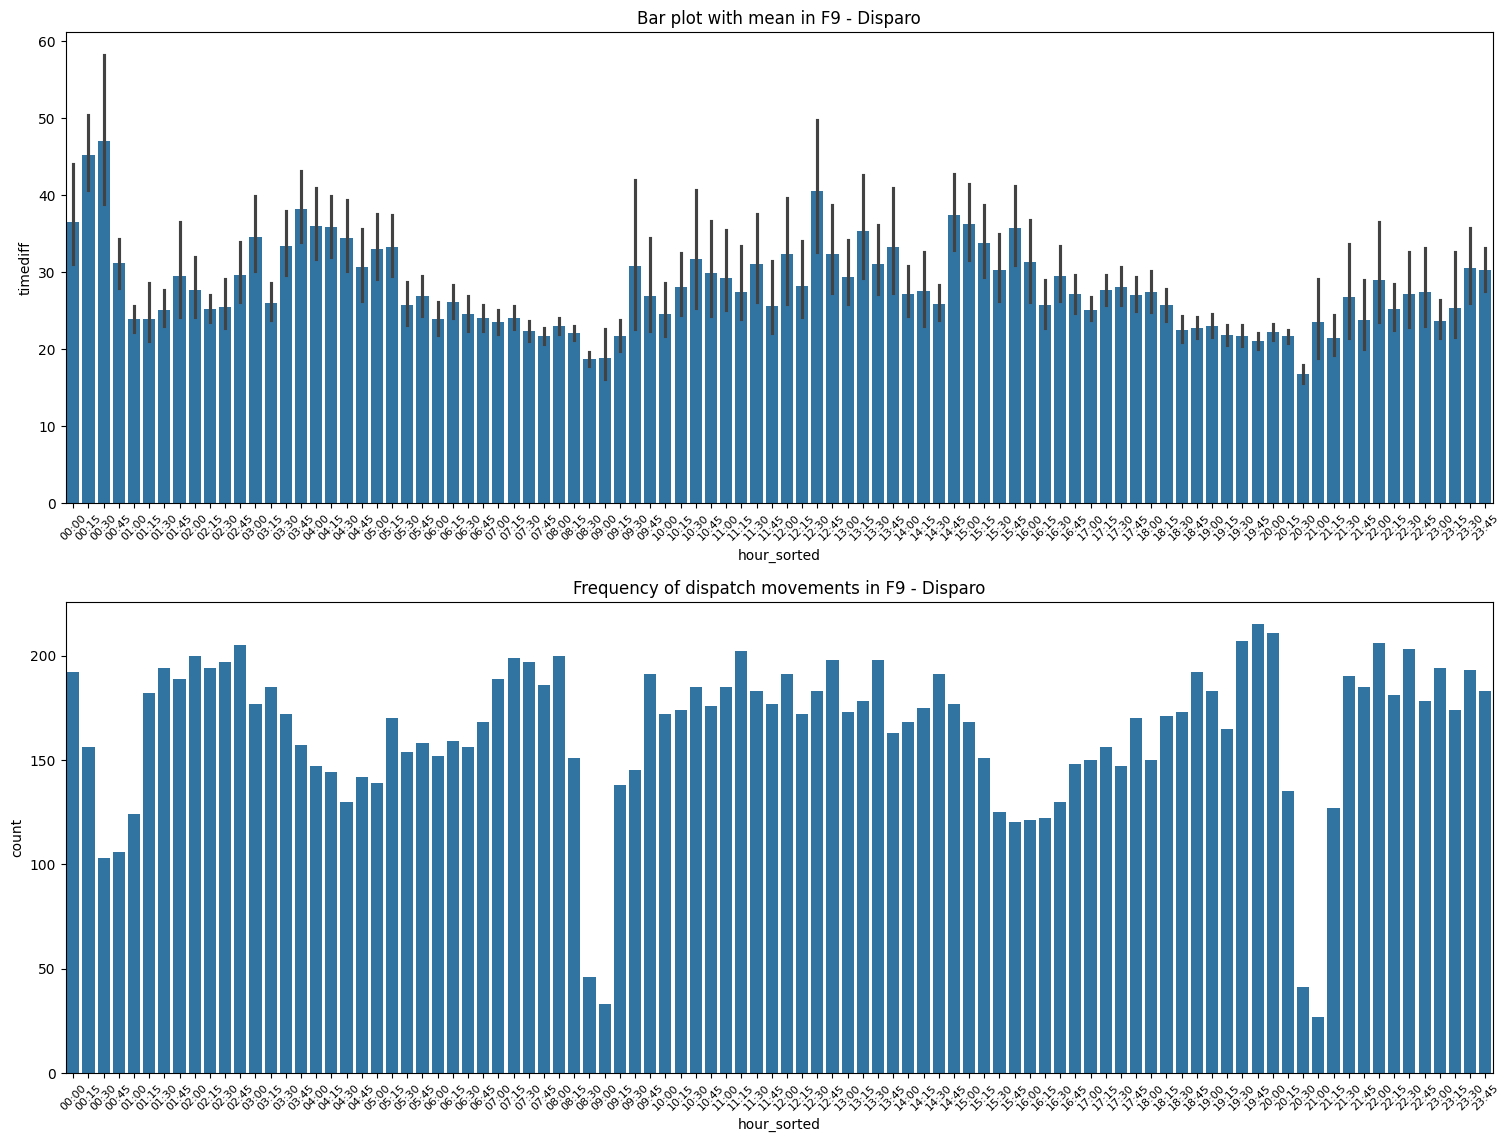

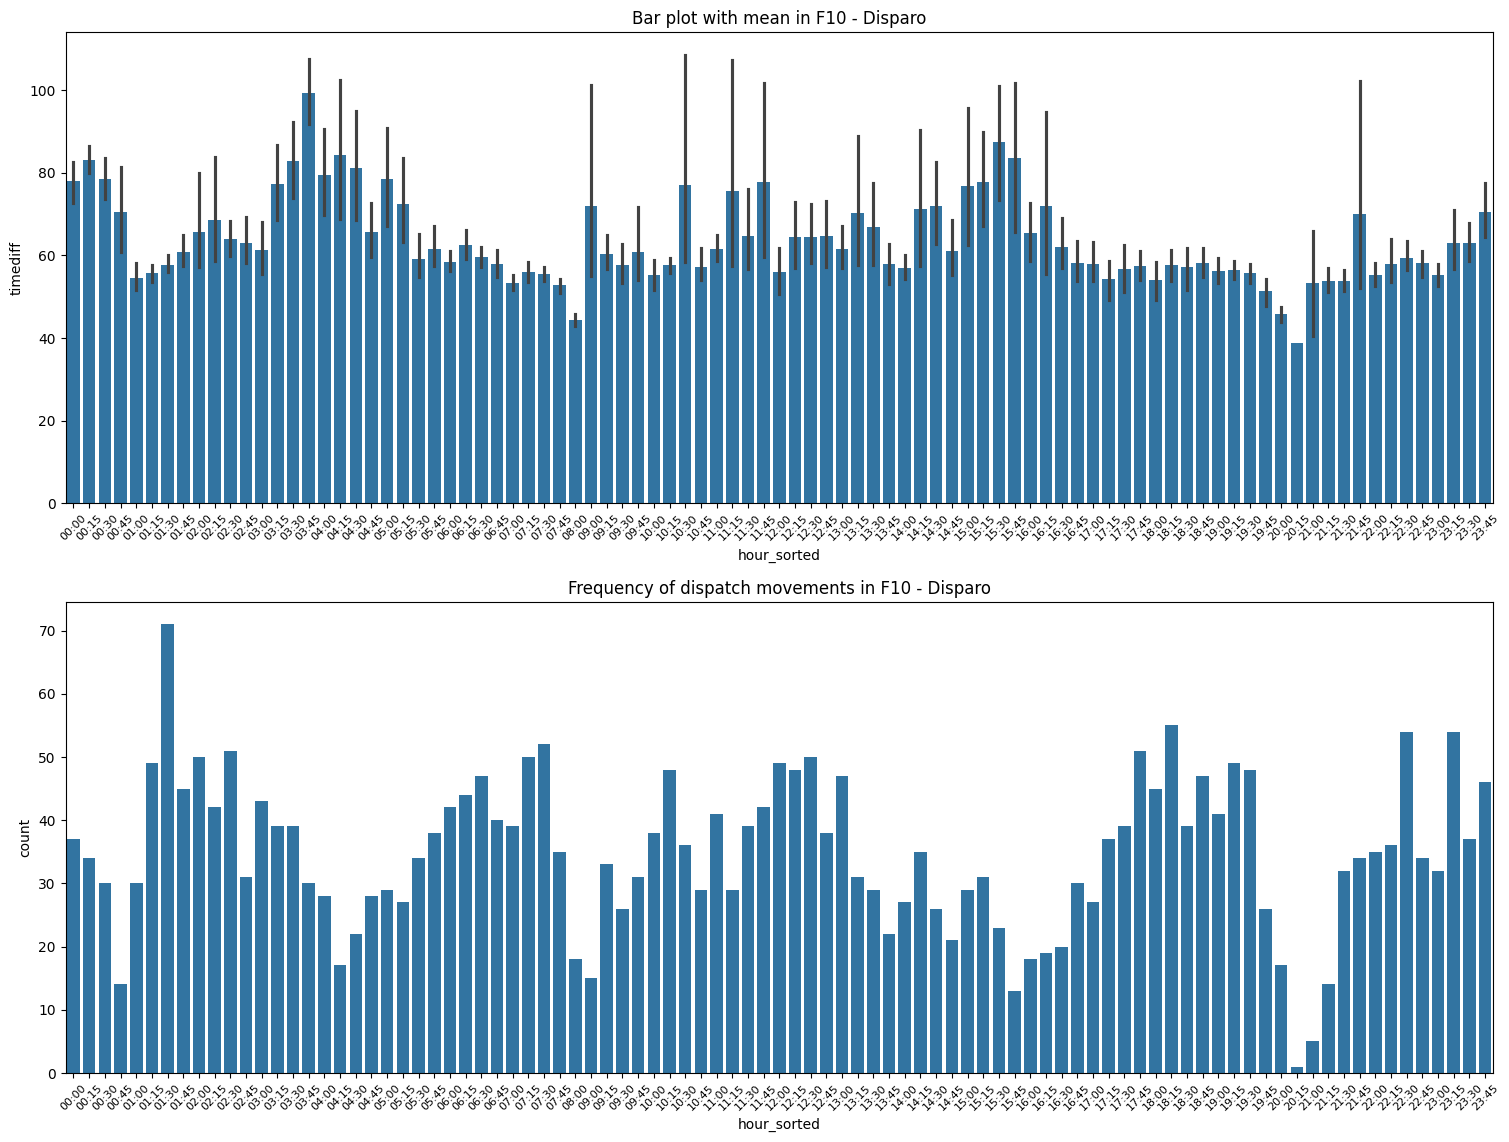

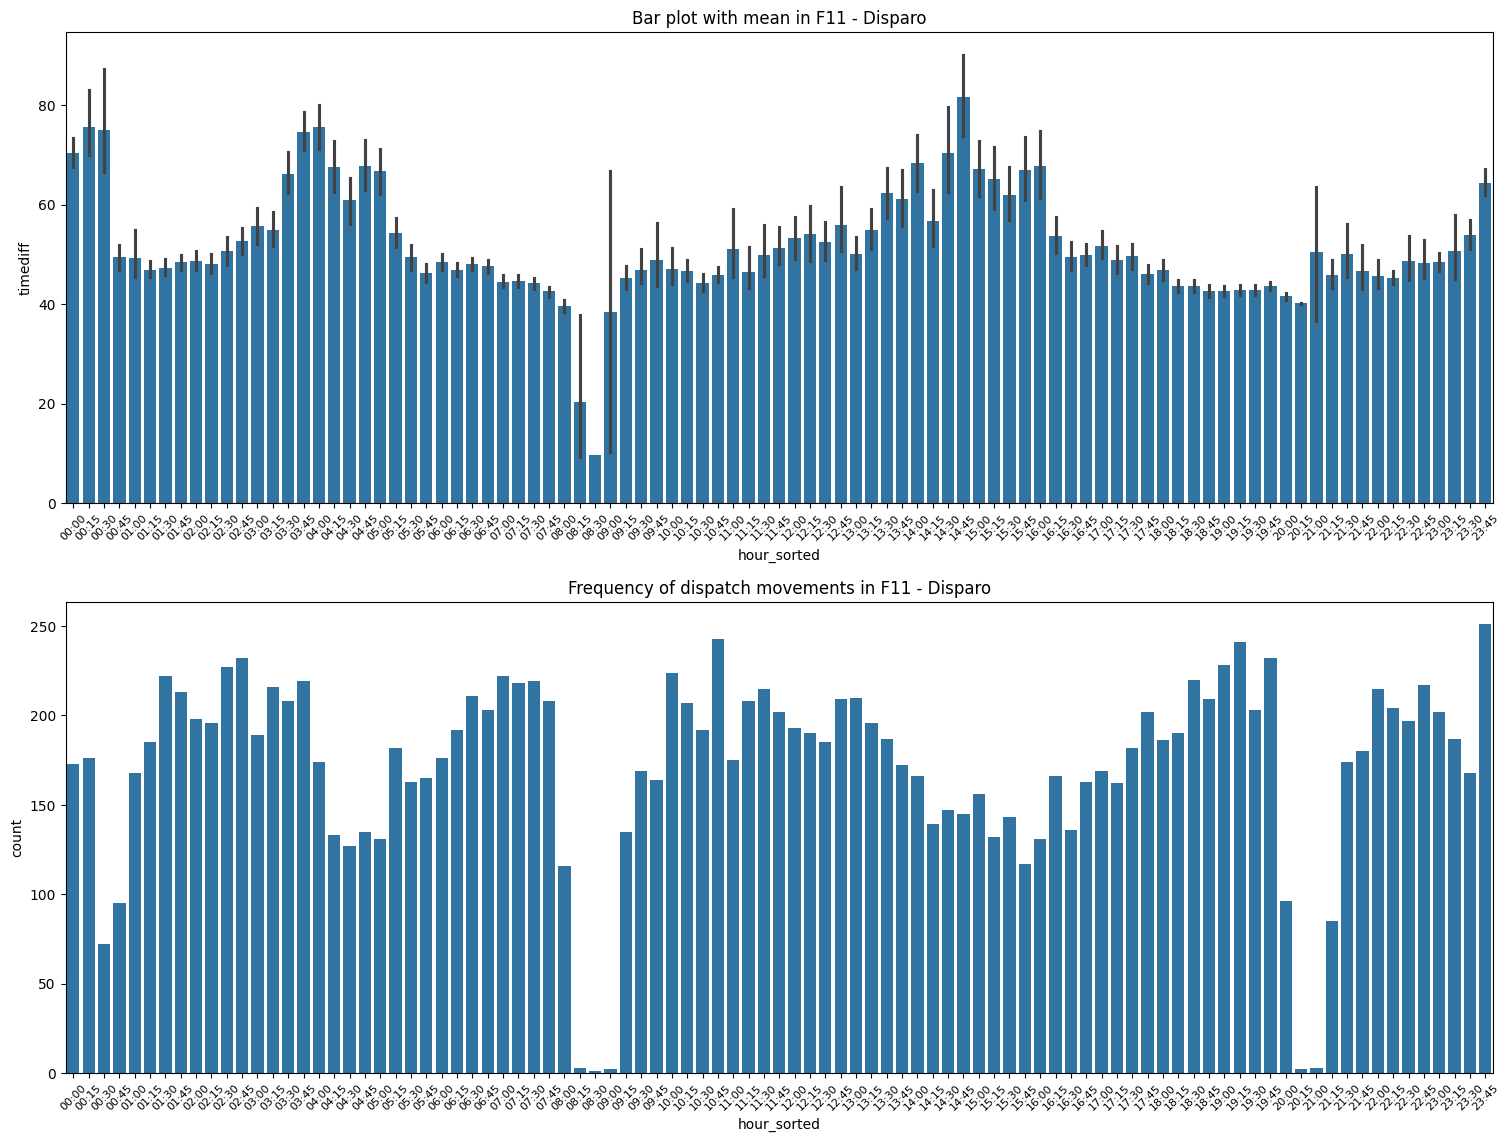

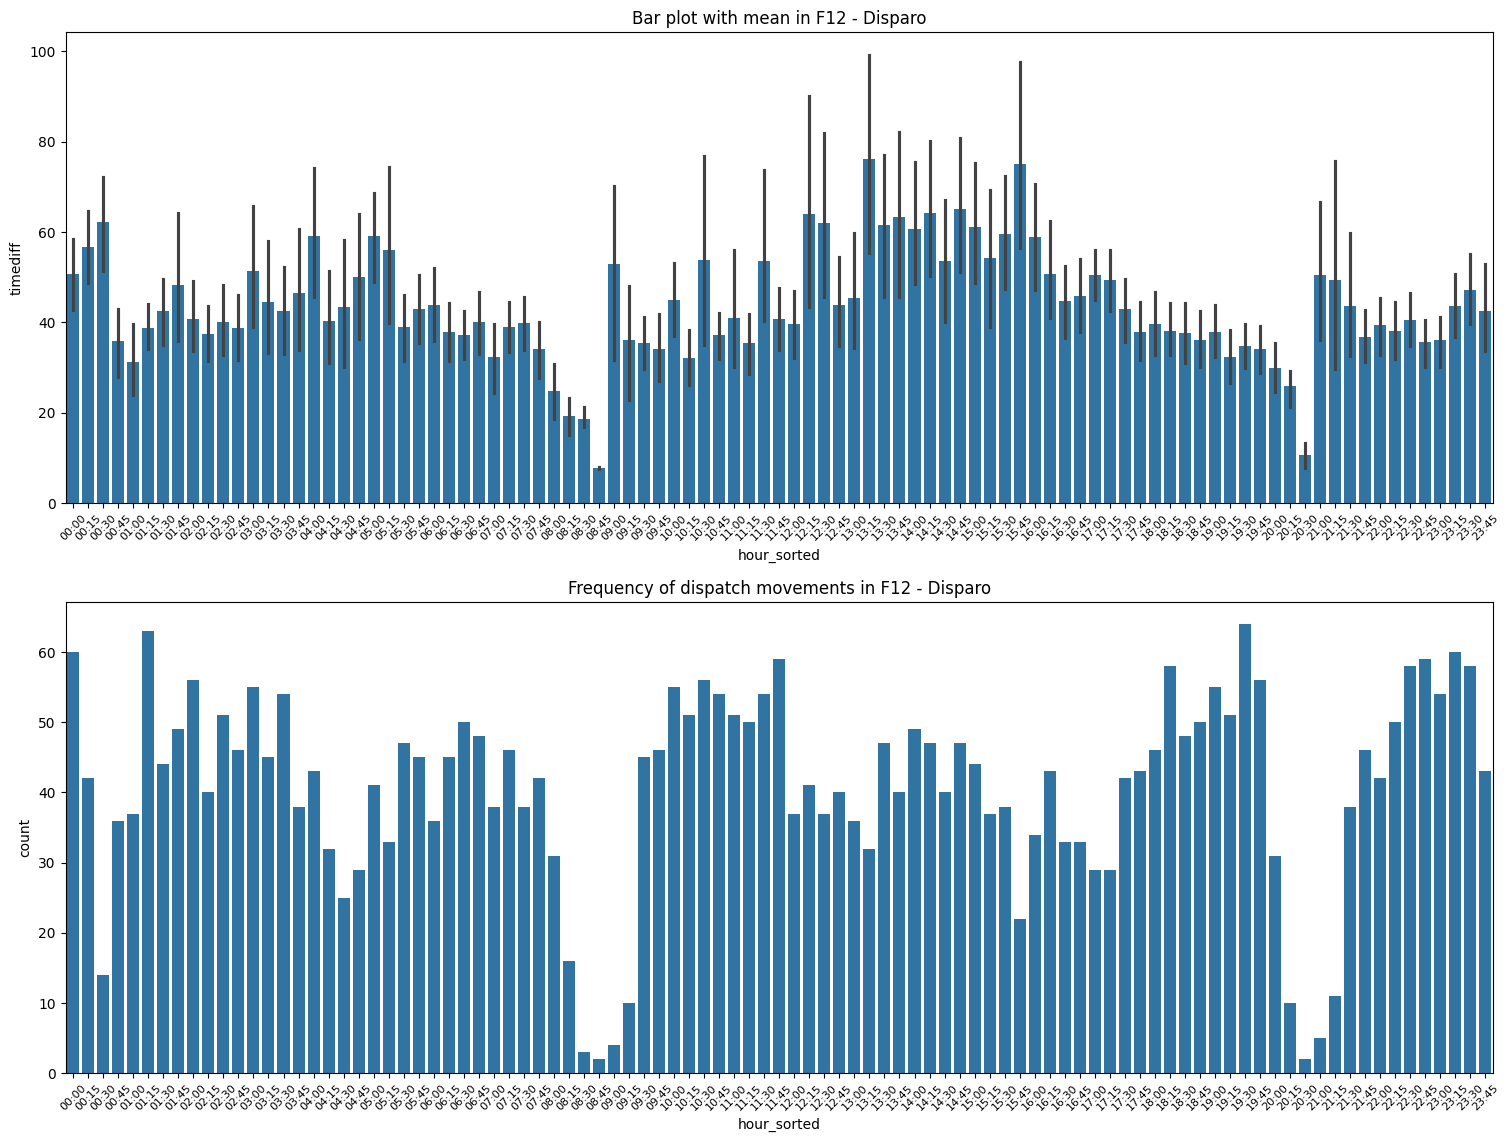

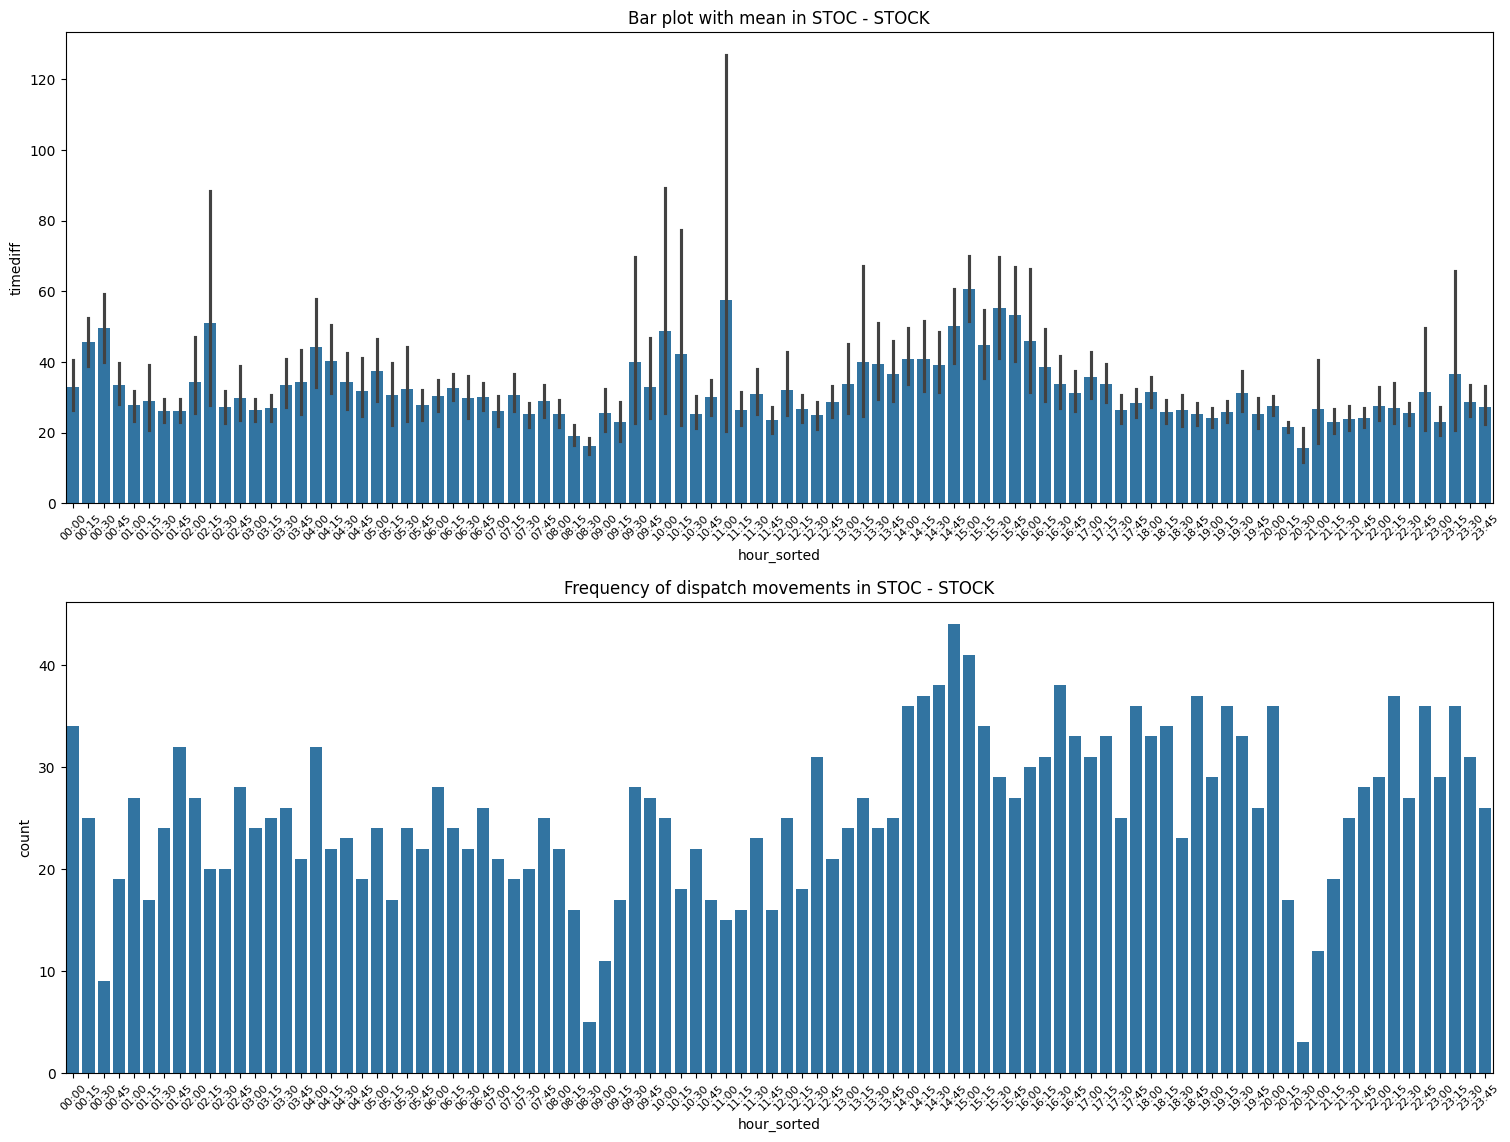

In [163]:
# df: df_f9_disparo, df_f10_disparo, df_f11_disparo, df_f12_disparo, df_stock
plot_process_time(df_f9_disparo, 'F9 - Disparo')
plot_process_time(df_f10_disparo, 'F10 - Disparo')
plot_process_time(df_f11_disparo, 'F11 - Disparo')
plot_process_time(df_f12_disparo, 'F12 - Disparo')
plot_process_time(df_stock, 'STOC - STOCK')